In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'fb7984e30caf463299d7bdba17d9b77e')

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'beach ball')
ims = results.attrgot('contentUrl')
print(len(ims), ims[0], ims[1])

150 https://photos.cdn-outlet.com/photos/7530600-2-zoomin.jpg https://cdn11.bigcommerce.com/s-ggt0qg2q7p/images/stencil/1280x1280/products/516/427/Swimline_9002_46_jumbo_inflatable_beach_ball__23317.1511276116.jpg?c=2?imbypass=on


In [7]:
#ims = ['https://m.media-amazon.com/images/I/61Jigwd1kKL._AC_SL1500_.jpg']

In [8]:
dest = 'images/beachball.jpg'
download_url(ims[0], dest)

Path('images/beachball.jpg')

In [9]:
ball_types = ['beach', 'tennis', 'golf']
path = Path('Balls')
path

Path('Balls')

In [10]:
if not path.exists():
    path.mkdir()
    for o in ball_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} ball')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#430) [Path('Balls/tennis/00000055.jpg'),Path('Balls/tennis/00000139.jpeg'),Path('Balls/tennis/00000107.jpg'),Path('Balls/tennis/00000030.jpg'),Path('Balls/tennis/00000097.jpg'),Path('Balls/tennis/00000148.jpg'),Path('Balls/tennis/00000145.jpeg'),Path('Balls/tennis/00000110.jpg'),Path('Balls/tennis/00000029.jpg'),Path('Balls/tennis/00000112.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#0) []

In [13]:
failed.map(Path.unlink);

In [14]:
balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = balls.dataloaders(path)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


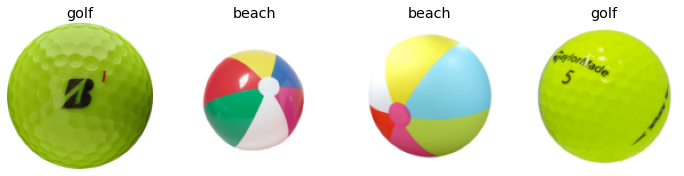

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

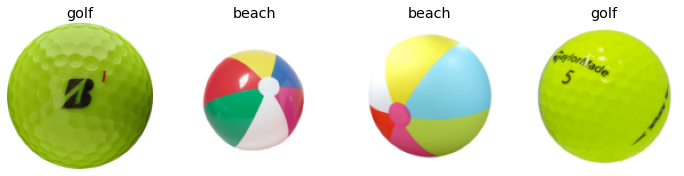

In [17]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

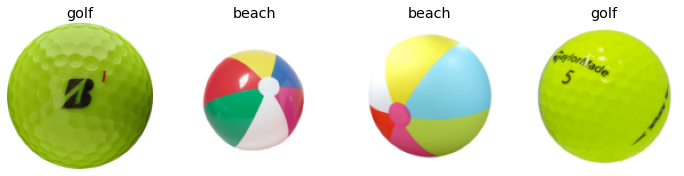

In [18]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

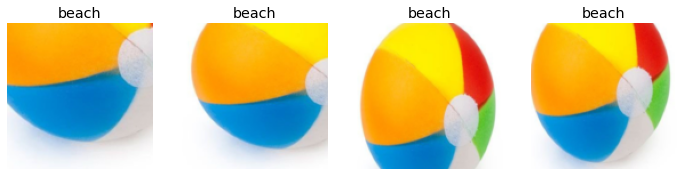

In [19]:
balls = balls.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Could not do one pass in your dataloader, there is something wrong in it


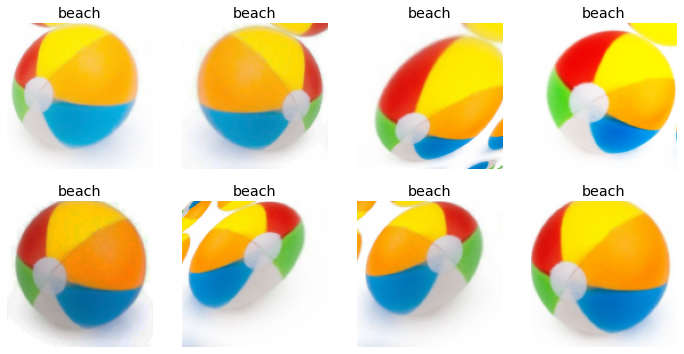

In [20]:
balls = balls.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
#Training

In [22]:
balls = balls.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = balls.dataloaders(path)

In [29]:
#Model creation
#Convolutional Neural Network with resnet18 architecture
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.600522,0.273371,0.081395,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.358121,0.135870,0.046512,00:11
1,0.242096,0.126174,0.023256,00:12
2,0.169500,0.116387,0.023256,00:13
3,0.133268,0.111996,0.023256,00:12


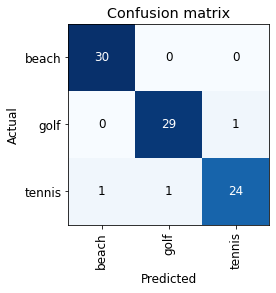

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

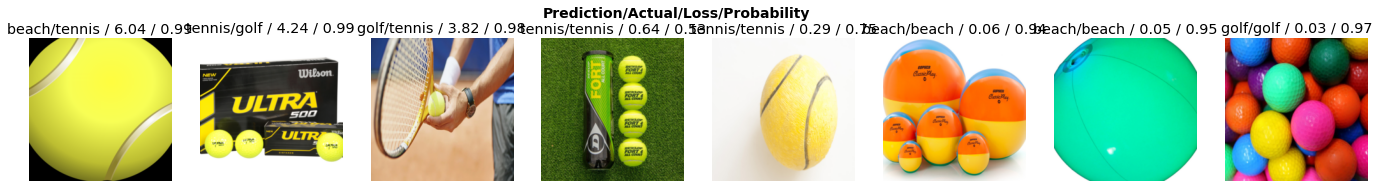

In [32]:
interp.plot_top_losses(8, nrows=1)

In [33]:
#clean the data
cleaner = ImageClassifierCleaner(learn)
cleaner

In [36]:
#Export model
learn.export()

In [37]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [39]:
learn_inf = load_learner(path/'export.pkl')

In [41]:
prediction = learn_inf.predict('images/beachball.jpg')


In [42]:
learn.dls.vocab

['beach', 'golf', 'tennis']

In [43]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

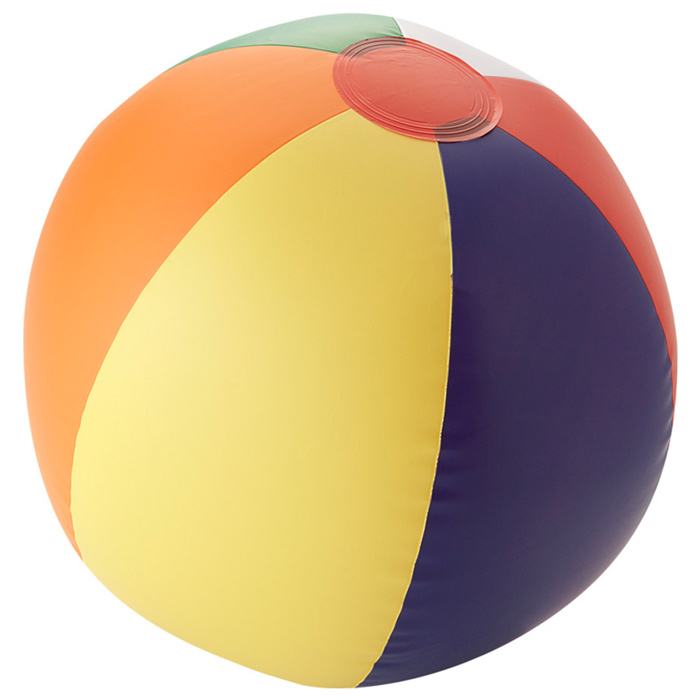

In [45]:
img = PILImage.create(btn_upload.data[0])
img

In [58]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [59]:
pred,pred_idx,probs = learn_inf.predict(img)

In [60]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Upload an image and press Classify!'
lbl_pred

Label(value='Upload an image and press Classify!')

In [61]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [62]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [63]:
btn_upload = widgets.FileUpload()

In [65]:
VBox([widgets.Label('Select your ball!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [66]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 556 kB 45.5 MB/s eta 0:00:01
     |████████████████████████████████| 396 kB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 63.1 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 14.4 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.3.0 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.0 OK
